# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 1 Aug 2020

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [99]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

_DATADIR="../_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-08-01.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")

# set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"])
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

# Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# create new column for day of week
cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name())
cumul_ams["Day"].astype("str")
# create new column for week number
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week)

# compare day on day increments/deltas
def get_daily_delta(df):
    daily_delta_column = []
    rep = df["Total_reported"]
    for i in range(0,len(rep)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(rep.iloc[i]-rep.iloc[i-1])

    return daily_delta_column

# add daily deltas to df
cumul_ams.insert(
    len(cumul_ams.columns),
    "Daily_delta",
    get_daily_delta(cumul_ams)
)

### Get only the data we want from dataframe

In [100]:
# create working df with:
# date, cumulative day of week, week number, reports

cumuldf = cumul_ams[["Date_of_report","Day","Week","Daily_delta", "Total_reported"]]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 109 to 51856
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date_of_report  142 non-null    datetime64[ns]
 1   Day             142 non-null    object        
 2   Week            142 non-null    int64         
 3   Daily_delta     142 non-null    int64         
 4   Total_reported  142 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.7+ KB


### Data from last 10 days

In [101]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Daily_delta,Total_reported
48553,2020-07-23,Thursday,30,15,2906
48920,2020-07-24,Friday,30,19,2925
49287,2020-07-25,Saturday,30,20,2945
49654,2020-07-26,Sunday,30,28,2973
50021,2020-07-27,Monday,31,47,3020
50388,2020-07-28,Tuesday,31,29,3049
50755,2020-07-29,Wednesday,31,27,3076
51122,2020-07-30,Thursday,31,68,3144
51489,2020-07-31,Friday,31,43,3187
51856,2020-08-01,Saturday,31,61,3248


In [102]:
def get_week_start_end(df, week_number):
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)

    :param df: pandas dataframe
    :type df: pandas.Dataframe
    :param week_number: ordinal number of week in year. Get using pandas.Series.dt.week
    :type week_number: int
    :return: (week_start, week_end)
    :rtype: Tuple
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df, delta_col="Date_of_report", n=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart

    :param df:
    :type df: pandas.DataFrame
    :param delta_col: pandas Series/df column that contains daily figures to plot, week by week
    :param n: Last n weeks
    :type n: int
    :return: None
    """
    plt.grid(True)
    plt.xticks(rotation="vertical")
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5))

    for week in range(0,n):
        this_week_number = df["Week"].max() - week
        this_week = df[df["Week"] == this_week_number]
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(this_week["Day"],this_week["Daily_delta"],label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend()

### Plot day to day change in reported cases, by week

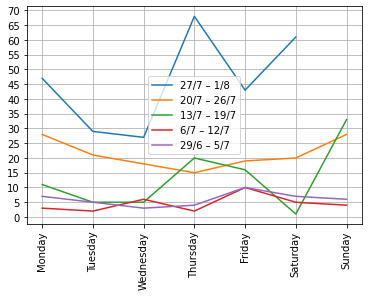

,Date_of_report,Week,Daily_delta,Total_reported
49654,2020-07-26,30,28,2973
50021,2020-07-27,31,47,3020
50388,2020-07-28,31,29,3049
50755,2020-07-29,31,27,3076
51122,2020-07-30,31,68,3144
51489,2020-07-31,31,43,3187
51856,2020-08-01,31,61,3248


In [103]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [104]:
def plot_weekly_delta_for_last_n_weeks(df, n):
    """
    Plot the weekly delta for the last n weeks

    :param df: dataframe
    :type df: pandas.DataFrame
    :param n: Last n weeks
    :type n: int
    :return: Dict
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week change in reported cases

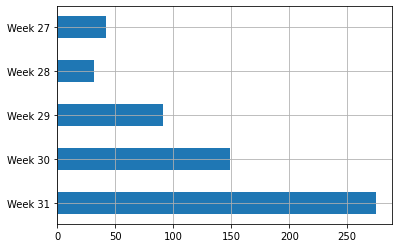

{'Week 27': 42, 'Week 28': 32, 'Week 29': 91, 'Week 30': 149, 'Week 31': 275}


In [105]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [106]:
def weekly_percentage_incr_for_last_n_weeks(df, n):
    weekly_percent_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(
                f"Week no. {df['Week'].max() - week} does not exist."
            )
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[
            df["Week"] == this_week_num
        ]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_percent_delta[
                f"Week {this_week_num}"] = 0
            continue
        else:
            last_week_delta = df[
                df["Week"] == (this_week_num-1)
            ]["Daily_delta"].sum()

            weekly_percent_delta[f"Week {this_week_num}"] = \
                ((week_delta-last_week_delta)/last_week_delta)*100

    return weekly_percent_delta

### Plot week-on-week percentage change in reported cases

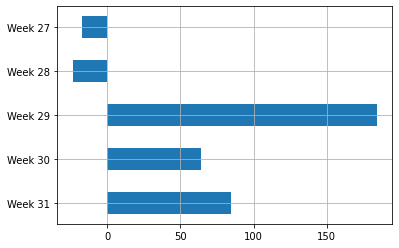

{'Week 27': -17.647058823529413,
 'Week 28': -23.809523809523807,
 'Week 29': 184.375,
 'Week 30': 63.73626373626373,
 'Week 31': 84.56375838926175}


In [107]:
plt.grid(True)
weekly_percent_delta = \
    weekly_percentage_incr_for_last_n_weeks(cumuldf,5)
plt.barh(
    list(weekly_percent_delta.keys()),
    width=np.array(list(weekly_percent_delta.values())),
    height=0.5)
plt.show()
pprint(weekly_percent_delta)

In [108]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df,n):
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical")
    plt.yticks(plot_this["Total_reported"])
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this["Total_reported"],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", "Total_reported"]].tail(n))

### Cumulative reported cases for the last 7 days

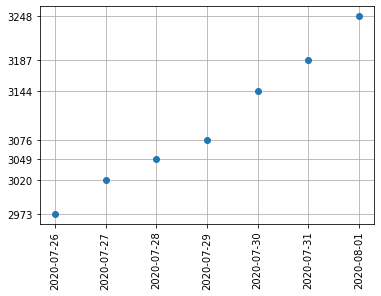

      Date_of_report  Total_reported
49654     2020-07-26            2973
50021     2020-07-27            3020
50388     2020-07-28            3049
50755     2020-07-29            3076
51122     2020-07-30            3144
51489     2020-07-31            3187
51856     2020-08-01            3248


In [109]:
plot_cumul_reported_last_n_days(cumuldf, 7)

### Cumulative reported cases for the last 14 days

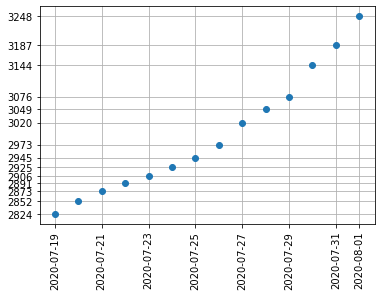

      Date_of_report  Total_reported
47085     2020-07-19            2824
47452     2020-07-20            2852
47819     2020-07-21            2873
48186     2020-07-22            2891
48553     2020-07-23            2906
48920     2020-07-24            2925
49287     2020-07-25            2945
49654     2020-07-26            2973
50021     2020-07-27            3020
50388     2020-07-28            3049
50755     2020-07-29            3076
51122     2020-07-30            3144
51489     2020-07-31            3187
51856     2020-08-01            3248


In [110]:
plot_cumul_reported_last_n_days(cumuldf, 14)

### Cumulative reported cases for the last 30 days

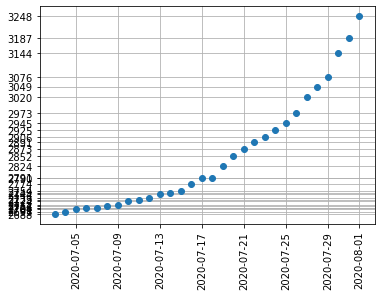

      Date_of_report  Total_reported
41213     2020-07-03            2688
41580     2020-07-04            2695
41947     2020-07-05            2701
42314     2020-07-06            2704
42681     2020-07-07            2706
43048     2020-07-08            2712
43415     2020-07-09            2714
43782     2020-07-10            2724
44149     2020-07-11            2729
44516     2020-07-12            2733
44883     2020-07-13            2744
45250     2020-07-14            2749
45617     2020-07-15            2754
45984     2020-07-16            2774
46351     2020-07-17            2790
46718     2020-07-18            2791
47085     2020-07-19            2824
47452     2020-07-20            2852
47819     2020-07-21            2873
48186     2020-07-22            2891
48553     2020-07-23            2906
48920     2020-07-24            2925
49287     2020-07-25            2945
49654     2020-07-26            2973
50021     2020-07-27            3020
50388     2020-07-28            3049
5

In [111]:
plot_cumul_reported_last_n_days(cumuldf, 30)